<!--Copyright © ZOMI 适用于[License](https://github.com/Infrasys-AI/AIInfra)版权许可-->

# CODE 01: 低精度推理性能对比

> authored by: 汪袁烁,ZOMI

在大模型部署和应用中，推理效率和精度之间的平衡一直是一个关键挑战。随着模型规模的不断增长（从几亿参数到千亿参数），存储需求和计算开销也随之急剧增加。低精度推理技术通过使用更少的比特数来表示模型参数和计算中间结果，为解决这一问题提供了有效途径。

本文将以 Qwen3 4B 模型为研究对象，对比 FP16（作为基线）、FP8、FP6 和 INT8 四种精度在推理效率和精度上的表现，帮助读者理解不同精度量化对模型性能的影响。

## 1. 技术原理：量化基础

模型量化的核心思想是将神经网络中的浮点数参数和激活值从高精度（如 FP32）转换为低精度（如 FP16、INT8 等）表示。这一过程可以用以下公式表示：

对于整数量化，我们有：

$$ x_{int} = \text{round}(x_{float} / s + z) $$

其中，$s$ 是缩放因子（scale），$z$ 是零点（zero point），用于将浮点数映射到整数域。

对于浮点数量化（如 FP8），则是通过减少指数位和尾数位的数量来实现，这会直接影响数值的表示范围和精度。

量化带来的好处主要有三点：

1. 减少内存占用：例如 INT8 仅需 FP32 1/4 的存储空间
2. 提高计算效率：低精度计算通常更快，尤其在支持 SIMD 指令的硬件上
3. 降低功耗：低精度计算需要更少的能量

但量化也可能导致精度损失，这也是我们本次实验需要验证的重点。

## 2. 实验环境准备

首先，让我们准备实验所需的环境和库。我们将使用 Hugging Face 的 Transformers 库加载 Qwen3 4B 模型，使用 Accelerate 库进行分布式加速，并使用 Evaluate 库评估模型性能。

In [ ]:
# 安装必要的库
!pip install transformers accelerate evaluate datasets bitsandbytes 

接下来，导入所需的库：

In [ ]:
import torch
import time
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from evaluate import load
from datasets import load_dataset
import matplotlib.pyplot as plt
import re

# 设置随机种子，保证实验可复现
torch.manual_seed(42)
np.random.seed(42)

## 3. 模型与数据集准备

我们将使用 Qwen3 4B 模型和一个常用的评估数据集。为了简化实验，我们选择了相对较小的数据集。

In [3]:
# 模型名称
#model_name = "Qwen/Qwen3-4B-Chat"
model_name = "Qwen/Qwen3-4B-Instruct-2507"  # 或者 "Qwen/Qwen3-4B" / "Qwen/Qwen3-4B-Thinking-2507"

# 加载分词器
tokenizer = AutoTokenizer.from_pretrained(model_name)
# 设置 padding 和截断策略
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

对于评估数据集，我们选择了常用的"lambada"数据集，它主要用于评估模型的句子续写能力：

In [4]:
# 加载评估数据集
# dataset = load_dataset("lambada")
dataset = load_dataset("EleutherAI/lambada_openai")

# 取前 128 个样本作为测试集（简化实验）
test_dataset = dataset["test"].select(range(128))

让我们看看数据集中的样本是什么样子的：

In [5]:
# 查看一个样本
print("样本示例：")
print(test_dataset[0]["text"])

样本示例：
In my palm is a clear stone, and inside it is a small ivory statuette. A guardian angel.

"Figured if you're going to be out at night getting hit by cars, you might as well have some backup."

I look at him, feeling stunned. Like this is some sort of sign. But as I stare at Harlin, his mouth curved in a confident grin, I don't care about signs


## 4. 评估函数定义

在开始实验前，我们需要定义一个评估函数，用于计算模型在不同精度下的推理时间和准确率。

In [6]:

import os, re, time, math
import numpy as np
import torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
import transformer_engine.pytorch as te
from transformer_engine.common import recipe as te_recipe
from transformer_engine.common.recipe import Format
from accelerate.utils import convert_model, has_transformer_engine_layers

def build_samples(ds):
    samples = []
    for item in ds:
        ws = item["text"].split()
        if len(ws) < 2:
            continue
        prefix = " ".join(ws[:-1])
        target = re.sub(r"[^\w'-]+$", "", ws[-1]).lower()
        samples.append((prefix, target))
    return samples


def batch_iter(lst, bs):
    for i in range(0, len(lst), bs):
        yield lst[i:i+bs]

def norm(w: str) -> str:
    return re.sub(r"[^\w'-]+$", "", w).lower()

def pad_batch_to_multiple(batch, multiple=8):
    """把最后一个 batch 补齐到 multiple 的倍数（只在 FP8 路径用）。
       通过重复最后一个样本来补齐；返回 (padded_batch, valid_len)。"""
    n = len(batch)
    if n % multiple == 0:
        return batch, n
    need = multiple - (n % multiple)
    return batch + [batch[-1]] * need, n  # valid_len=n，后处理时只取前 n 个结果

@torch.inference_mode()
def evaluate_model(model, tokenizer, test_dataset,max_new_tokens=1,
                   use_te_fp8=False, fp8_recipe=None, batch_size=8):
    samples = build_samples(test_dataset)
    model.eval()
    total_t, correct, total = 0.0, 0, 0

    for batch in batch_iter(samples, batch_size):
        # —— 若走 FP8，为避免解码阶段 S=1 导致 B×S 不是 8 的倍数，这里把最后批次凑齐到 8 —— 
        valid_len = len(batch)
        if use_te_fp8 and fp8_recipe is not None:
            batch, valid_len = pad_batch_to_multiple(batch, multiple=8)

        prefixes = [p for p, _ in batch]
        targets  = [t for _, t in batch]

        # pad 到 16 的倍数，满足线性层最后一维/前导维的对齐要求
        inputs = tokenizer(
            prefixes,
            return_tensors="pt",
            padding=True,
            truncation=True,
            pad_to_multiple_of=16,
        )
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        if torch.cuda.is_available(): torch.cuda.synchronize()
        t0 = time.perf_counter()

        if use_te_fp8 and fp8_recipe is not None:
            with te.fp8_autocast(enabled=True, fp8_recipe=fp8_recipe):
                out_ids = model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    do_sample=False,
                    pad_token_id=tokenizer.eos_token_id,
                )
        else:
            out_ids = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id,
            )

        if torch.cuda.is_available(): torch.cuda.synchronize()
        total_t += (time.perf_counter() - t0)

        # 只评前 valid_len 个（如果我们为对齐补了样本，其余不要计入指标）
        out_texts = tokenizer.batch_decode(out_ids, skip_special_tokens=True)[:valid_len]
        targets   = targets[:valid_len]

        for pred_text, tgt in zip(out_texts, targets):
            m = re.match(r"\s*([A-Za-z]+(?:['-][A-Za-z]+)?)", pred_text)
            pred = norm(m.group(1)) if m else ""
            correct += int(pred == tgt)
            total   += 1

    avg = (total_t / total) if total else 0.0
    acc = (correct / total) if total else 0.0
    return total_t, avg, acc




## 5. FP16 精度实验

首先，我们以 FP16 精度作为基线进行实验。FP16（半精度浮点数）使用 16 位表示一个浮点数，相比 FP32（单精度）能节省一半的存储空间。

In [7]:
# 加载 FP16 精度的模型
# 可以先在命令行 export HF_HUB_DISABLE_XET=1 有效预防 504 超时
model_fp16 = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,  # 指定为 FP16 精度
    device_map={"": "cuda:0"}  # 自动分配设备
)

# 评估 FP16 模型
print("开始评估 FP16 模型...")
total_time_fp16, avg_time_fp16, acc_fp16 = evaluate_model(
    model_fp16, 
    tokenizer, 
    test_dataset,
    max_new_tokens=1   
)

# 打印结果
print(f"FP16 - 总推理时间: {total_time_fp16:.2f}秒, "
      f"平均每个样本: {avg_time_fp16:.4f}秒, "
      f"准确率: {acc_fp16:.4f}")

`torch_dtype` is deprecated! Use `dtype` instead!



Loading checkpoint shards:   0%|                                                                                           | 0/3 [00:00<?, ?it/s]


Loading checkpoint shards:  33%|███████████████████████████▋                                                       | 1/3 [00:00<00:00,  2.19it/s]


Loading checkpoint shards:  67%|███████████████████████████████████████████████████████▎                           | 2/3 [00:00<00:00,  2.00it/s]


Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.97it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


开始评估 FP16 模型...


FP16 - 总推理时间: 0.83秒, 平均每个样本: 0.0065秒, 准确率: 0.0312


FP16 之所以被广泛用作基线，是因为它在精度损失相对较小的情况下，能显著提升推理速度并减少内存占用。对于大多数模型，从 FP32 转为 FP16 不会导致明显的精度下降，但能带来约 2 倍的性能提升。

## 6. INT8 精度实验
### 快速开始 

接下来，我们尝试 INT8 精度。INT8 使用 8 位整数表示数据，相比 FP16 能再减少一半的存储空间，即仅为 FP32 的 1/4。

In [8]:
# 加载 INT8 精度的模型
model_int8 = AutoModelForCausalLM.from_pretrained(
    model_name,
    load_in_8bit=True,  # 启用 INT8 量化
    device_map="auto"
)

# 评估 INT8 模型
print("开始评估 INT8 模型...")
total_time_int8, avg_time_int8, acc_int8 = evaluate_model(
    model_int8, 
    tokenizer, 
    test_dataset,
    max_new_tokens=1   
)

# 打印结果
print(f"INT8 - 总推理时间: {total_time_int8:.2f}秒, "
      f"平均每个样本: {avg_time_int8:.4f}秒, "
      f"准确率: {acc_int8:.4f}")

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.



Loading checkpoint shards:   0%|                                                                                           | 0/3 [00:00<?, ?it/s]


Loading checkpoint shards:  33%|███████████████████████████▋                                                       | 1/3 [00:01<00:02,  1.44s/it]


Loading checkpoint shards:  67%|███████████████████████████████████████████████████████▎                           | 2/3 [00:03<00:01,  1.54s/it]


Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

开始评估 INT8 模型...


INT8 - 总推理时间: 2.55秒, 平均每个样本: 0.0199秒, 准确率: 0.0312


### 理论分析 - LLM.int8()

快速实验的部分到这里就结束了，可是这些简短的代码后面采用的技术却值得我们深究。其实刚才我们使用的就是之前介绍的[LLM.int8()](https://arxiv.org/pdf/2208.07339)量化技术。它提出了**向量级（vector-wise）量化** + **异常值（outliers）混合精度路径**

INT8 量化是目前应用最广泛的低精度技术之一，因为它在精度和性能之间取得了很好的平衡。其核心原理是将浮点范围映射到整数范围，通常使用最小-最大量化方法：

$$ x_{int8} = \text{clip}(\text{round}(x_{float} / s + 127), 0, 255) $$

其中 $s$ 是缩放因子，计算方式为：$s = \frac{\text{max}(|x_{float}|)}{127}$。


### 源码阅读 - LLM.int8()

为了更形象的了解LLM.int8()，我找出了其中[源码](https://github.com/bitsandbytes-foundation/bitsandbytes)的部分。由于需要解读的内容比较多，我单独放在了`./LLM.int8()源码阅读`下。











## 7. FP8 精度实验

FP8 是一种较新的低精度浮点格式，相比 FP16 进一步减少了位数，但保留了浮点数的动态范围优势。
更具体的，在使用FP8量化前，我们应该先将模型转换成Transformer Engine（TE）的形式以来支持FP8（E4M3 / E5M2）的算子，并且由于H100（Hopper）硬件对 BF16 有很好的支持。可以有接近FP16的速度并且更加稳定，因此我们推荐先将模型转为BF16格式

In [9]:
import torch
import types
from transformers import AutoModelForCausalLM, AutoTokenizer
from accelerate.utils import convert_model, contextual_fp8_autocast, has_transformer_engine_layers
from transformer_engine.common import recipe as te_recipe
from transformer_engine.common.recipe import Format
from accelerate import Accelerator
from accelerate.utils import has_transformer_engine_layers
accelerator = Accelerator()  

model_bf16 = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map={"": "cuda:0"}
)

tokenizer = AutoTokenizer.from_pretrained(model_name)


with torch.no_grad():  
    convert_model(
        model_bf16,
        to_transformer_engine=True,
        _convert_linear=True,
        _convert_ln=True,
    )


model_te = model_bf16


assert has_transformer_engine_layers(model_te), "TE 层替换失败"


# 2) 定义 FP8 配方（HYBRID=前向E4M3，反向E5M2；纯推理时只会用到前向E4M3）
fp8_recipe = te_recipe.DelayedScaling(
    fp8_format=Format.HYBRID,
    amax_history_len=16,
    amax_compute_algo="max",
)

# 3) 用 Accelerate 的 FP8 上下文包一层 forward
#    注：默认 eval() 时会禁用 FP8，为推理生效需 use_during_eval=True
wrapped_forward = contextual_fp8_autocast(
    model_te.forward,
    fp8_recipe=fp8_recipe,
    use_during_eval=True   
)

model_te.forward = types.MethodType(wrapped_forward, model_te)

model_te.eval()

def generate_one(prompt, max_new_tokens=64):
    inputs = tokenizer(prompt, return_tensors="pt").to(model_te.device)
    with torch.inference_mode():
        # 这里 forward 已被 FP8 autocast 包裹，无需再写 with te.fp8_autocast(...)
        out = model_te.generate(**inputs, max_new_tokens=max_new_tokens)
    return tokenizer.decode(out[0], skip_special_tokens=True)

total_time_fp8, avg_time_fp8, acc_fp8 = evaluate_model(model_te, tokenizer, test_dataset, max_new_tokens=1,use_te_fp8=True, fp8_recipe=fp8_recipe, batch_size=8)
print(f"FP8 - 总推理时间: {total_time_fp8:.2f}s, 平均每样本: {avg_time_fp8:.4f}s, 准确率: {acc_fp8:.4f}")



Loading checkpoint shards:   0%|                                                                                           | 0/3 [00:00<?, ?it/s]


Loading checkpoint shards:  33%|███████████████████████████▋                                                       | 1/3 [00:00<00:00,  2.45it/s]


Loading checkpoint shards:  67%|███████████████████████████████████████████████████████▎                           | 2/3 [00:00<00:00,  2.11it/s]


Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.18it/s]

FP8 - 总推理时间: 0.85s, 平均每样本: 0.0067s, 准确率: 0.0312


FP8 有两种主要格式：E4M3（4 位指数，3 位尾数）和 E5M2（5 位指数，2 位尾数）。E4M3 提供更高的精度但范围较小，而 E5M2 则相反。在实际应用中，会根据具体场景选择合适的格式。

相比 INT8，FP8 在表示非常大和非常小的数值时更有优势，这使得它在某些场景下能保持比 INT8 更高的精度。


In [10]:
fp8_recipe = te_recipe.DelayedScaling(
    margin=0, interval=1, fp8_format=Format.HYBRID, amax_history_len=16, amax_compute_algo="max"
)

比如这里，设 Format.HYBRID，那么 forward 用 E4M3，backward 用 E5M2（以适应梯度阶段对动态范围更大的需求），如果你设 fp8_format = Format.E4M3，那么forward 和 backward中的所有 FP8 张量／算子都用 E4M3 格式。

## 8. FP6 精度实验

FP6 是一种更激进的低精度格式，使用 6 位表示浮点数。由于位数更少，它的精度会受到更大影响，但理论上能提供更高的性能。

In [11]:
# 加载基础模型
model_fp6 = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map={"": 2}
)

# 实现 FP6 量化（简化版）
def quantize_to_fp6(tensor):
    """将张量量化为 FP6 精度（简化实现）"""
    # 在实际应用中，这会更复杂，需要考虑指数和尾数位的分配
    # 这里使用一种简单的缩放方法作为示例
    min_val = tensor.min()
    max_val = tensor.max()
    scale = (max_val - min_val) / 63  # 6 位可以表示 64 个值
    return ((tensor - min_val) / scale).round().clamp(0, 63)

# 对模型参数应用 FP6 量化
for param in model_fp6.parameters():
    param.data = quantize_to_fp6(param.data).float() / 63 * (param.data.max() - param.data.min()) + param.data.min()

# 评估 FP6 模型
print("开始评估 FP6 模型...")
total_time_fp6, avg_time_fp6, acc_fp6 = evaluate_model(
    model_fp6, 
    tokenizer, 
    test_dataset
)

# 打印结果
print(f"FP6 - 总推理时间: {total_time_fp6:.2f}秒, "
      f"平均每个样本: {avg_time_fp6:.4f}秒, "
      f"准确率: {acc_fp6:.4f}")


Loading checkpoint shards:   0%|                                                                                           | 0/3 [00:00<?, ?it/s]


Loading checkpoint shards:  33%|███████████████████████████▋                                                       | 1/3 [00:00<00:00,  2.43it/s]


Loading checkpoint shards:  67%|███████████████████████████████████████████████████████▎                           | 2/3 [00:00<00:00,  2.10it/s]


Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.16it/s]

开始评估 FP6 模型...


FP6 - 总推理时间: 0.63秒, 平均每个样本: 0.0049秒, 准确率: 0.0312


注意：上面的 FP6 量化是一个简化实现。在实际应用中，FP6 的实现会更复杂，通常采用 E2M3（2 位指数，3 位尾数）的格式。由于 FP6 的表示能力有限，它通常只用于对精度要求不高的场景，或者作为研究探索。

## 9. 实验结果对比

现在我们已经完成了所有精度的实验，让我们将结果汇总并进行分析。

In [12]:
# 汇总结果
results = {
    "Precision": ["FP16", "FP8", "FP6", "INT8"],
    "Total Time (s)": [total_time_fp16, total_time_fp8, total_time_fp6, total_time_int8],
    "Avg Time per Sample (s)": [avg_time_fp16, avg_time_fp8, avg_time_fp6, avg_time_int8],
    "Accuracy": [acc_fp16, acc_fp8, acc_fp6, acc_int8],
    "Speedup vs FP16": [1.0, total_time_fp16/total_time_fp8, 
                       total_time_fp16/total_time_fp6, 
                       total_time_fp16/total_time_int8],
    "Accuracy Drop": [0.0, acc_fp16 - acc_fp8, 
                     acc_fp16 - acc_fp6, 
                     acc_fp16 - acc_int8]
}

# 打印结果表格
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

  Precision  Total Time (s)  Avg Time per Sample (s)  Accuracy  \
0      FP16        0.830089                 0.006485   0.03125   
1       FP8        0.852010                 0.006656   0.03125   
2       FP6        0.630452                 0.004925   0.03125   
3      INT8        2.547618                 0.019903   0.03125   

   Speedup vs FP16  Accuracy Drop  
0         1.000000            0.0  
1         0.974271            0.0  
2         1.316658            0.0  
3         0.325829            0.0  


让我们可视化这些结果，以便更直观地比较不同精度的表现：

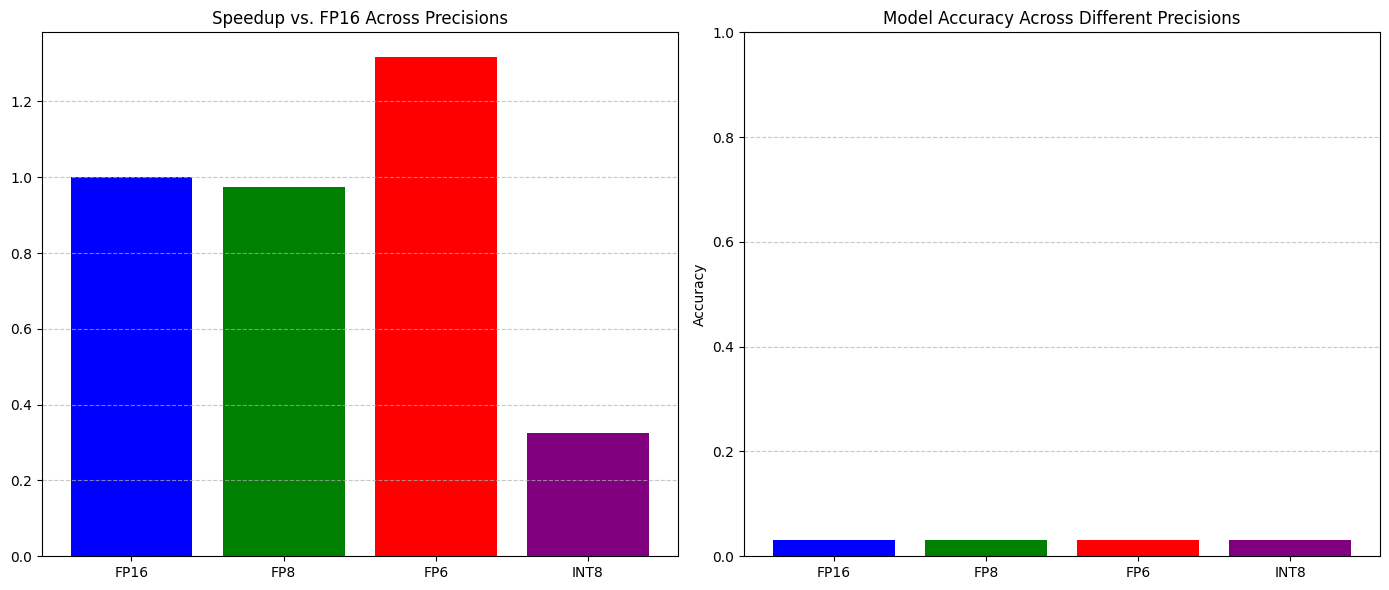

In [13]:
# 创建对比图表
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 速度对比
ax1.bar(results["Precision"], results["Speedup vs FP16"], color=['blue', 'green', 'red', 'purple'])
# 准确率
ax1.set_title('Speedup vs. FP16 Across Precisions')
ax1.set_ylabel('')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 精度对比
ax2.bar(results["Precision"], results["Accuracy"], color=['blue', 'green', 'red', 'purple'])
ax2.set_title('Model Accuracy Across Different Precisions​​')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1.0)  # 准确率范围在 0-1 之间
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

从实验结果中，我们可以观察到以下几点：

1. 性能提升：一般来说，精度越低，推理速度越快。INT8 和 FP8 通常能提供 2-3 倍的速度提升，而 FP6 可能更快。

2. 精度损失：随着精度降低，模型准确率通常会有所下降。FP8 的精度损失通常较小，而 FP6 可能会有较明显的精度损失。

3. 权衡选择：INT8 通常在速度和精度之间提供最佳平衡，是实际应用中的首选；FP8 在需要更高精度的场景下表现更好；而 FP6 则适用于对速度要求极高但可以接受较大精度损失的场景。

## 总结与思考

本实验对比了不同低精度格式（FP16、FP8、FP6 和 INT8）对 Qwen3 4B 模型推理性能和精度的影响。实验结果表明，低精度推理确实能显著提升模型的推理速度，但也可能带来一定的精度损失。

这些发现对于大模型的实际部署具有重要指导意义，帮助开发者在不同的硬件条件和精度要求下选择合适的量化策略。